In [1]:
# Importando módulos necessários
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

In [2]:
# Baixamos a data pré treinada e descompactar
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
# https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
!unzip modelNweight.zip

Downloading...
From: https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
To: /content/modelNweight.zip
100% 86.2M/86.2M [00:00<00:00, 222MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [3]:
# função que usamos para criar os quadrados nos rostos da imagem
def getFaceBox(net, frame, conf_threshold=0.7):
    # criamos uma cópia local do frame recebido
    frameOpencvDnn = frame.copy()
    # pegamos a altura do frame
    frameHeight = frameOpencvDnn.shape[0]
    # pegamos a largura do frame
    frameWidth = frameOpencvDnn.shape[1]
    # convertemos a imagem para blob para que a ia face os processamentos 
    # BLOB significa Binary Large OBject. Um blob é um tipo de dados que pode armazenar dados binários.
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    # enviamos o blob para a rede
    net.setInput(blob)
    # pegamos as detecções 
    detections = net.forward()
    # criamos a variavel para as caixas dos rostos
    bboxes = []
    for i in range(detections.shape[2]):
        # criamos uma variãvel para ser nosso valor de confiabilidade dessa detecção 
        # validações melhores e tentarmos excluir falsos positivos
        confidence = detections[0, 0, i, 2]
        # verificamos se o valor recebido nas validações são superiores ao nosso valor de corte
        if confidence > conf_threshold:
           # criando linhas do quadrado
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            # adicionamos ao array de caixas as linhas
            bboxes.append([x1, y1, x2, y2])
            # criamos os quadrados na imagem dos rostos encontrados
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

#carregamento de dados do collab. Por favor faça o upload de todos arquivos que enviamos para que funcione
faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"
ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"
genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

# passando os valores base para idade e gênero com os valores de modelos masculinos
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# fazemos o carregamento da nossa rede, caso de algum erro nesse momento carregue os .txt que enviamos juntos no collab
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Lendon o frame e pegando os rotos que a foto possui
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        
        # print(bbox)

        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        # convertemos a imagem para blob para que a ia face os processamentos 
        # BLOB significa Binary Large OBject. Um blob é um tipo de dados que pode armazenar dados binários.
        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        #enviamos o blob para a rede de validação de genero
        genderNet.setInput(blob)
        # pegamos os valores retornado da rede de gênero
        genderPreds = genderNet.forward()
        # retornamos o valor base de acordo com o retorno da rede de gênero
        gender = genderList[genderPreds[0].argmax()]
        #enviamos o blob para a rede de validação de idade
        ageNet.setInput(blob)
        # pegamos os valores retornado da rede de idade
        agePreds = ageNet.forward()
        # retornamos o valor base de acordo com o retorno da rede de idade
        age = ageList[agePreds[0].argmax()]
        label = "{},{}".format(gender, age)
        # colocando o texto e o range de idade na imagem
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

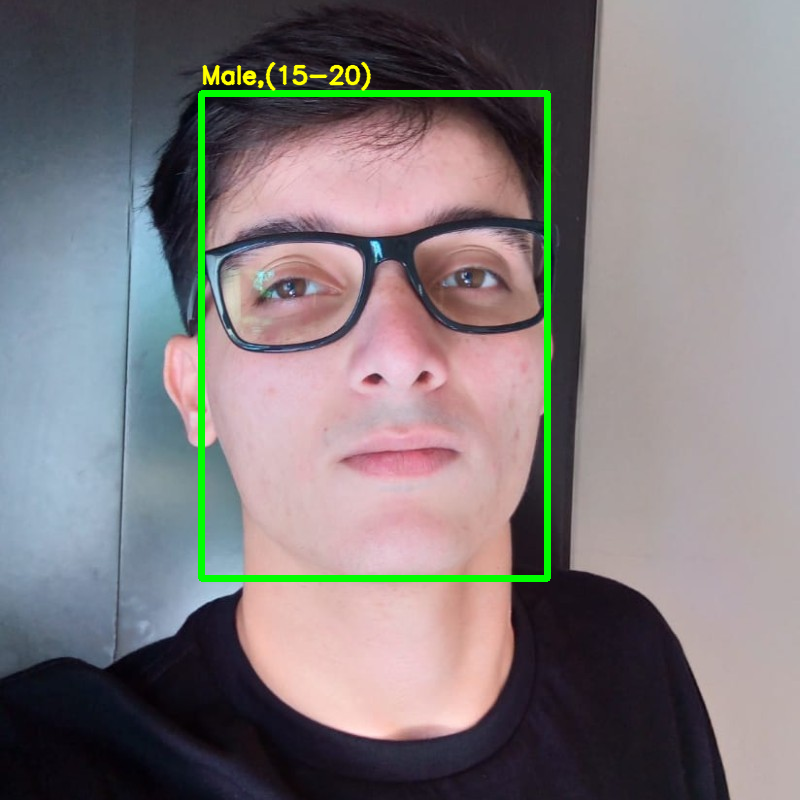

In [5]:
# aqui mostramos a foto com o resultado, faça o upload de qualquer foto colocando qual a extensão dela
# aviso, caso a extesnão esteja errada, irá gerar um erro
input = cv.imread("avatar.jpeg")
output = age_gender_detector(input)
cv2_imshow(output)